* V0.1 contains only code for applying Gaussian Likelihood via -ve squared error proxy
* Prior and posterior dist are the same as original CVAE code
tested over
1. mnist and fasion mnist - good visual results
2. cifar10, bas visual results (hypothesis - bad convolution layer, prior , maybe even Likelihood


TODO
1. Convert data to continous # done
2. Experiment with cross entropy likelihood vs Gaussian Likelihood # done
3. **Investigate Gaussian log p calculation with reduce axis and reshape methods (math and experiemntal)**

4. experiment simple dataset first (mnist, fashion, cifar10) with different likelihoods # done

visually
* mnist and fasion_mnist are fine
* cifar not fine (investigate why- might be the convolutional layer, or th prior) 

5. **change the posteriors to GMM and start with making sure k=1 is the same as original single gaussian posterior**
7. investigate how to determine the best latent dim

In [1]:
# ref Gaussian Regression likelihood
# https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf

In [2]:
%config Completer.use_jedi = False
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import pandas as pd
import logging

In [3]:
logging.basicConfig(level = logging.INFO)
main_logger = logging.getLogger('Main_Logger')

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
train_images = tf.convert_to_tensor(train_images,dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images,dtype=tf.float32)

In [5]:
train_images.shape

TensorShape([60000, 28, 28])

In [6]:
type(train_images)

tensorflow.python.framework.ops.EagerTensor

In [7]:
# configs
channel = 0

In [8]:
def preprocess_images(images): # inputs are tensors
    shape = images.shape.as_list()
    if len(shape)==4 and shape[3]==3: #possibly colored
        main_logger.info('Converting batched colored images dataset to grayscale')
        images = tf.cast(tf.image.rgb_to_grayscale(images),dtype=tf.float32)
        main_logger.info(f'Colored image shape ')
    elif len(shape)==3: # grayscale
        images = tf.reshape(tensor=images,shape=tf.constant([shape[0],shape[1],shape[2],1]))
    images /=255.
    return images # np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [9]:
train_size = train_images.shape[0]
batch_size = 16
test_size = test_images.shape[0]

In [10]:
train_images.shape,test_images.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [11]:
train_dataset = (tf.data.Dataset.from_tensor_slices(tf.cast(train_images,tf.float32))
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(tf.cast(test_images,tf.float32))
                .shuffle(test_size).batch(batch_size))

In [12]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.logger = logging.getLogger('CVAE')
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7 * 7 * 32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )
        self.logger.info('Decoder')
        self.logger.info(self.decoder.summary())

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        x_bar = self.decoder(z)
        return x_bar

In [13]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


def compute_loss(model, x):
    logger = logging.getLogger('compute_loss')
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_hat = model.decode(z)
    
    """
    * Main idea : -ve loss as a proxy for log likelihood, in the context of maximizing the likelihood
    * Calculate log p(x|z), assuming x|z is bernoulli 
    * Use -ve cross enropy loss as a proxy for log p(x|z ) maximization , up to a constant
    """
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=x)
    logpx_z_cross_ent =  -tf.reduce_sum(cross_ent, axis=[1, 2, 3])

    """
    ! Wrong piece of code 
    * TODO : investigate why it is wrong
    
    new_shape = (x.shape.as_list()[0],x.shape.as_list()[1]*x.shape.as_list()[2]*x.shape.as_list()[3])
    x_rs = tf.reshape(x,new_shape)
    x_hat_rs = tf.reshape(x_hat,new_shape)
    
    """
    
    """
    * Calculate log p(x|z), assuming x|z is gaussian 
    * Use -ve mse loss as a proxy for log p(x|z ) maximization , up to a constant
     See https://stats.stackexchange.com/a/16534
    * For each sample x belongs to R^D, having n samples: 
    
    log p(x|z) = 0.5*sigma^-2(y-y_hat)^2+Z 
    Z = -d/2{(log(2*pi) +sigma)}
    where sigma is the common assumed variance for all dimenstions y = {y_d}^{d=1:D}, all dimensions are indep
    can be extended to the case of a diagonal covariance matrix of sigma_i , i = 1:D in the diagonal
    
    hence
    * for each sample of n sampels:
    log p(x|z ) is proptional to -SE (SE = Sum_(over dimenstions, d)(y_hat-y))
    """

    e = tf.subtract(x,x_hat)
    se = tf.math.multiply(e,e)
    logpx_z_mse = -tf.reduce_sum(se,axis=[1,2,3])
    logpx_z_se = -tf.reduce_sum(se,axis=[1,2,3])
    

    logpz = log_normal_pdf(z, 0., 0.) # TODO, revisit
    logqz_x = log_normal_pdf(z, mean, logvar)
    
    loss = -tf.reduce_mean(logpx_z_se + logpz - logqz_x) # loss = -elbo

    return loss



def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [14]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 16
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

INFO:CVAE:Decoder
INFO:CVAE:None


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1568)              26656     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 63,905
Trainable params: 63,905
Non-trainable params: 0
_________________________________________________________________


In [15]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(test_sample.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(test_sample[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()    
    for i in range(predictions.shape[0]):
        # main_logger.info(f'mean of predictions = {tf.reduce_mean(predictions[i])}')
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [16]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

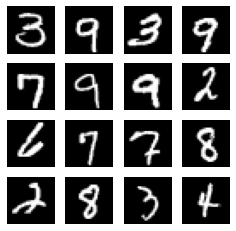

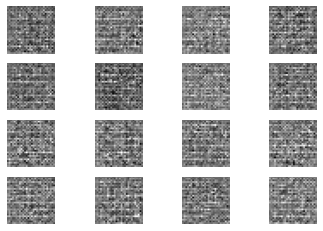

Epoch: 1, Test set ELBO: -35.535804748535156, time elapse for current epoch: 84.80351400375366


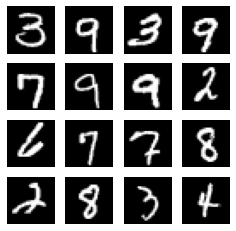

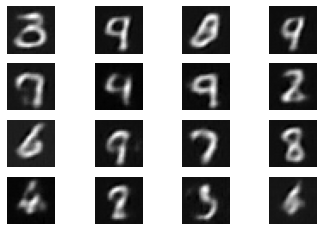

KeyboardInterrupt: 

In [17]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    train_batches = int(train_images.shape[0]/batch_size)
    for i in range(train_batches):
        train_batch = train_images[i*batch_size:(i+1)*batch_size,:,:,:]
        train_step(model, train_batch, optimizer)
    end_time = time.time()
    
    
    loss = tf.keras.metrics.Mean()
    
    test_batches = int(test_images.shape[0]/batch_size)
    for j in range(test_batches):
        test_batch = test_images[j*batch_size:(j+1)*batch_size,:,:,:]
        loss(compute_loss(model, test_batch))
    elbo = -loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
          .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)